# Whale Detection Challenge : Preprocess

Method overview : FFT to convert the sound tracks into spectrograms, and apply distinct preprocessing methods such as clipping, noise removal, PCEN and filters. After preprocessing we feed the spectrograms into state of the art light CNN models such as Resnet 18, VGG 16 or GoogleNet to identify right whale call patterns and perform classification. We may also try the removal of pooling layers in the networks and see if it causes better outcome.

In [1]:
import scipy.stats
import numpy as np
import aifc
import matplotlib.pyplot as plt
from matplotlib import mlab, cm
import matplotlib.ticker as plticker
import matplotlib
import pathlib
import pandas as pd
import os
import cv2
import librosa
import librosa.display
import time
import skimage
import shutil

## Preprocess Section

### Preprocessing 0 : contrast-enhanced spectrograms

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


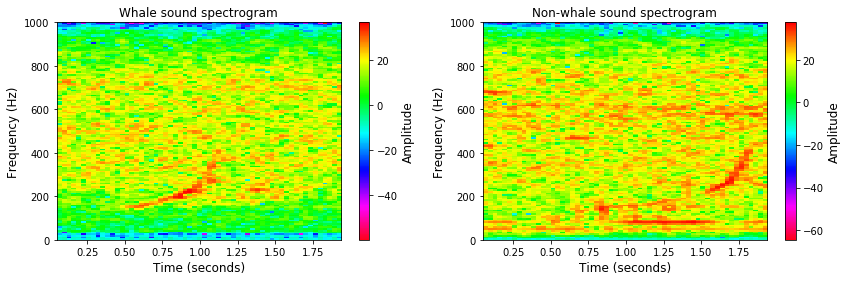

In [2]:
path_data = './data/'
# ReadAIFF function
def ReadAIFF(file):
#Reads the frames from the audio clip and returns the uncompressed data '
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

def plot_sbs_spectrogram(filename_whale, filename_non_whale):
    whale = ReadAIFF(filename_whale)
    nonwhale = ReadAIFF(filename_non_whale)
    plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    my_cmap = matplotlib.cm.get_cmap('hsv_r');
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    plt.specgram(whale, **params);
    ax1.set_title('Whale sound spectrogram', fontsize = 12)
    ax1.set_xlabel('Time (seconds)', fontsize = 12)
    ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    ax2 = plt.subplot(122)
    plt.specgram(nonwhale, **params);
    ax2.set_title('Non-whale sound spectrogram', fontsize = 12)
    ax2.set_xlabel('Time (seconds)', fontsize = 12)
    ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    plt.show()
   
# Compare several examples:
plot_sbs_spectrogram(path_data+'train/train6.aiff', path_data+'train/train1.aiff')

In [3]:
# transform all aiffs to np.ndarray and save
def to_spec_and_enhance(filename):
    data = ReadAIFF(filename)
    my_cmap = matplotlib.cm.get_cmap('hsv_r');
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    spectrum,freq,t,im = plt.specgram(data, **params)
    image_enhanced = scipy.stats.zscore(spectrum, axis=None)
    image_enhanced = 255*(image_enhanced - image_enhanced.min()) / (image_enhanced.max() - image_enhanced.min())
    image_enhanced = image_enhanced.astype(np.uint8)
    #print(image_enhanced)
    #print(np.amin(image_enhanced))
    #print(np.amax(image_enhanced))
    image_enhanced = cv2.equalizeHist(image_enhanced)
    #print(type(np.transpose(spectrum)))
    #print(np.transpose(spectrum).shape)
    return np.transpose(image_enhanced)

### Preprocessing 1 : noise removal

In [4]:
# Convolution and then filter
def noiseFilter(image_array, inner=3, vouter=59, houter=32, maxM=50, norm=True):
    P=image_array
    Q=P.copy()
    Q=cv2.fastNlMeansDenoising(Q)
    m,n=Q.shape
    if(norm):
        mval,sval=np.mean(Q[:maxM,:]),np.std(Q[:maxM,:])
        # Extreme values are capped to mean ± 1.5 std
        fact_=1.5
        upper=mval+fact_*sval   
        lower=mval-fact_*sval
        Q[Q>upper]=upper
        Q[Q<lower]=lower
    wInner=np.ones(inner)
    vOuter=np.ones(vouter)
    hOuter=np.ones(houter)
    #convolution
    #for i in range(n):
    #    Q[:,i]=Q[:,i]-(np.convolve(Q[:,i],vOuter,'same')-np.convolve(Q[:,i],wInner,'same'))/(vouter-inner)
    #for i in range(m):
    #    Q[i,:]=Q[i,:]-(np.convolve(Q[i,:],hOuter,'same')-np.convolve(Q[i,:],wInner,'same'))/(houter-inner)

    return Q[:maxM,:]

###  Preprocessing 2 : filters

###  Preprocessing 3 : PCEN 

In [5]:
# please install librosa first
# pip install librosa

# We recommend scaling the spec data to the range [-2**31, 2**31[ 
# we use magnitude spectrum instead of a power spectrum.

def PCEN(image_array):
    db_img = image_array      
    # it uses amp_img instead of db
    amp_img = librosa.db_to_amplitude(db_img)
    amp_img = amp_img/np.max(amp_img)
#     print(np.max(amp_img))
    
# #     log_S = librosa.amplitude_to_db(S, ref=np.max)
#     # scale the value to the maximum range
    pcen_img = librosa.pcen(amp_img * (2**31))
    
    # disable display when is not debugging
#     plt.clf()
#     plt.figure()
#     plt.subplot(2,1,1)
#     librosa.display.specshow(db_img, x_axis='time', y_axis='mel')
    
#     plt.title('log amplitude (dB)')
#     plt.colorbar()
#     plt.subplot(2,1,2)
#     librosa.display.specshow(pcen_img, x_axis='time', y_axis='mel')
#     plt.title('Per-channel energy normalization')
#     plt.colorbar()
#     plt.tight_layout()
#     plt.show()
    
    ## modification
#     plt.figure()
#     ax1 = plt.subplot(2, 1, 1)
#     my_cmap = matplotlib.cm.get_cmap('hsv_r');
#     plt.imshow(db_img);
#     ax1.set_xlabel('Time (seconds)', fontsize = 12)
#     ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
#     cbar = plt.colorbar()
#     cbar.set_label('Amplitude', fontsize = 12)
    
#     ax2 = plt.subplot(2, 1, 2)
#     plt.imshow(pcen_img)
#     ax2.set_xlabel('Time (seconds)', fontsize = 12)
#     ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
#     cbar = plt.colorbar()
#     cbar.set_label('Amplitude', fontsize = 12)
#     plt.show()
    
    return pcen_img



### Preprocessing 4 : template matching

###  Preprocessing 5 : clipping

### Save proprocess data

In [8]:
train_dir = './data/train/'
# test_dir = './data/test/'
# train_spec_dir = './data/train_prep_10/'
train_spec_dir = './data/val_prep_10/'
# test_spec_dir = './data/test_prep_2layers/'
def save_transformed_data(src_dir,dst_dir):
    cnt=1
    try:
        shutil.rmtree(dst_dir)
    except OSError as e:
        print("Error: %s : %s" % (dst_dir, e.strerror))
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for filename in os.listdir(src_dir):
        if filename.endswith(".aiff"): 
            #print(filename)
            src_path=os.path.join(src_dir,filename)
            dst_path=os.path.join(dst_dir,filename[:-5]+".png")
            
            print("%s %d",src_path,cnt)
            cnt+=1
            if(cnt % 10 == 0):
                #print(src_path)
                #print(dst_path)
                processed = to_spec_and_enhance(src_path)
                processed = noiseFilter(processed)
                processed = PCEN(processed)
    #             processed = skimage.transform.resize(processed, (224,224))
                processed = cv2.resize(processed, (224, 224))

                matplotlib.image.imsave(dst_path,processed)
            
def arrange_transformed_data(src_dir, dst_dir):
    csv_path="data/train.csv"
    train_label = pd.read_csv(csv_path)
    try:
        shutil.rmtree(dst_dir)
    except OSError as e:
        print("Error: %s : %s" % (dst_dir, e.strerror))
    if not os.path.exists(dst_dir+"0/"):
        os.makedirs(dst_dir+"0/")
    if not os.path.exists(dst_dir+"1/"):
        os.makedirs(dst_dir+"1/") 
    for i in range(train_label.shape[0]):
        if( i % 10 == 1 ): # val
#         if( i % 10 == 0 ): # train
            src_path=os.path.join(src_dir,train_label['clip_name'][i])
            print("%s %d",src_path,i)
            processed = to_spec_and_enhance(src_path)
            processed = noiseFilter(processed)
            processed = PCEN(processed)
#           Padding  
            processed = skimage.transform.resize(processed, (224,224))
#           Scaling
#             processed = cv2.resize(processed, (224, 224))
            print(processed.shape)
            if(train_label['label'][i]==1):
                dst_path = os.path.join(dst_dir+"1/",train_label['clip_name'][i][:-5]+".png")
                matplotlib.image.imsave(dst_path,processed)    
            elif (train_label['label'][i]==0):
                dst_path=os.path.join(dst_dir+"0/",train_label['clip_name'][i][:-5]+".png")
                matplotlib.image.imsave(dst_path,processed) 

%s %d ./data/train/train2.aiff 1
(224, 224)
%s %d ./data/train/train12.aiff 11
(224, 224)
%s %d ./data/train/train22.aiff 21


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


(224, 224)
%s %d ./data/train/train32.aiff 31
(224, 224)
%s %d ./data/train/train42.aiff 41
(224, 224)
%s %d ./data/train/train52.aiff 51
(224, 224)
%s %d ./data/train/train62.aiff 61
(224, 224)
%s %d ./data/train/train72.aiff 71
(224, 224)
%s %d ./data/train/train82.aiff 81
(224, 224)
%s %d ./data/train/train92.aiff 91
(224, 224)
%s %d ./data/train/train102.aiff 101
(224, 224)
%s %d ./data/train/train112.aiff 111
(224, 224)
%s %d ./data/train/train122.aiff 121
(224, 224)
%s %d ./data/train/train132.aiff 131
(224, 224)
%s %d ./data/train/train142.aiff 141
(224, 224)
%s %d ./data/train/train152.aiff 151
(224, 224)
%s %d ./data/train/train162.aiff 161
(224, 224)
%s %d ./data/train/train172.aiff 171
(224, 224)
%s %d ./data/train/train182.aiff 181
(224, 224)
%s %d ./data/train/train192.aiff 191
(224, 224)
%s %d ./data/train/train202.aiff 201
(224, 224)
%s %d ./data/train/train212.aiff 211
(224, 224)
%s %d ./data/train/train222.aiff 221
(224, 224)
%s %d ./data/train/train232.aiff 231
(224, 

%s %d ./data/train/train1732.aiff 1731
(224, 224)
%s %d ./data/train/train1742.aiff 1741
(224, 224)
%s %d ./data/train/train1752.aiff 1751
(224, 224)
%s %d ./data/train/train1762.aiff 1761
(224, 224)
%s %d ./data/train/train1772.aiff 1771
(224, 224)
%s %d ./data/train/train1782.aiff 1781
(224, 224)
%s %d ./data/train/train1792.aiff 1791
(224, 224)
%s %d ./data/train/train1802.aiff 1801
(224, 224)
%s %d ./data/train/train1812.aiff 1811
(224, 224)
%s %d ./data/train/train1822.aiff 1821
(224, 224)
%s %d ./data/train/train1832.aiff 1831
(224, 224)
%s %d ./data/train/train1842.aiff 1841
(224, 224)
%s %d ./data/train/train1852.aiff 1851
(224, 224)
%s %d ./data/train/train1862.aiff 1861
(224, 224)
%s %d ./data/train/train1872.aiff 1871
(224, 224)
%s %d ./data/train/train1882.aiff 1881
(224, 224)
%s %d ./data/train/train1892.aiff 1891
(224, 224)
%s %d ./data/train/train1902.aiff 1901
(224, 224)
%s %d ./data/train/train1912.aiff 1911
(224, 224)
%s %d ./data/train/train1922.aiff 1921
(224, 224)


(224, 224)
%s %d ./data/train/train3392.aiff 3391
(224, 224)
%s %d ./data/train/train3402.aiff 3401
(224, 224)
%s %d ./data/train/train3412.aiff 3411
(224, 224)
%s %d ./data/train/train3422.aiff 3421
(224, 224)
%s %d ./data/train/train3432.aiff 3431
(224, 224)
%s %d ./data/train/train3442.aiff 3441
(224, 224)
%s %d ./data/train/train3452.aiff 3451
(224, 224)
%s %d ./data/train/train3462.aiff 3461
(224, 224)
%s %d ./data/train/train3472.aiff 3471
(224, 224)
%s %d ./data/train/train3482.aiff 3481
(224, 224)
%s %d ./data/train/train3492.aiff 3491
(224, 224)
%s %d ./data/train/train3502.aiff 3501
(224, 224)
%s %d ./data/train/train3512.aiff 3511
(224, 224)
%s %d ./data/train/train3522.aiff 3521
(224, 224)
%s %d ./data/train/train3532.aiff 3531
(224, 224)
%s %d ./data/train/train3542.aiff 3541
(224, 224)
%s %d ./data/train/train3552.aiff 3551
(224, 224)
%s %d ./data/train/train3562.aiff 3561
(224, 224)
%s %d ./data/train/train3572.aiff 3571
(224, 224)
%s %d ./data/train/train3582.aiff 3581


(224, 224)
%s %d ./data/train/train5062.aiff 5061
(224, 224)
%s %d ./data/train/train5072.aiff 5071
(224, 224)
%s %d ./data/train/train5082.aiff 5081
(224, 224)
%s %d ./data/train/train5092.aiff 5091
(224, 224)
%s %d ./data/train/train5102.aiff 5101
(224, 224)
%s %d ./data/train/train5112.aiff 5111
(224, 224)
%s %d ./data/train/train5122.aiff 5121
(224, 224)
%s %d ./data/train/train5132.aiff 5131
(224, 224)
%s %d ./data/train/train5142.aiff 5141
(224, 224)
%s %d ./data/train/train5152.aiff 5151
(224, 224)
%s %d ./data/train/train5162.aiff 5161
(224, 224)
%s %d ./data/train/train5172.aiff 5171
(224, 224)
%s %d ./data/train/train5182.aiff 5181
(224, 224)
%s %d ./data/train/train5192.aiff 5191
(224, 224)
%s %d ./data/train/train5202.aiff 5201
(224, 224)
%s %d ./data/train/train5212.aiff 5211
(224, 224)
%s %d ./data/train/train5222.aiff 5221
(224, 224)
%s %d ./data/train/train5232.aiff 5231
(224, 224)
%s %d ./data/train/train5242.aiff 5241
(224, 224)
%s %d ./data/train/train5252.aiff 5251


%s %d ./data/train/train6722.aiff 6721
(224, 224)
%s %d ./data/train/train6732.aiff 6731
(224, 224)
%s %d ./data/train/train6742.aiff 6741
(224, 224)
%s %d ./data/train/train6752.aiff 6751
(224, 224)
%s %d ./data/train/train6762.aiff 6761
(224, 224)
%s %d ./data/train/train6772.aiff 6771
(224, 224)
%s %d ./data/train/train6782.aiff 6781
(224, 224)
%s %d ./data/train/train6792.aiff 6791
(224, 224)
%s %d ./data/train/train6802.aiff 6801
(224, 224)
%s %d ./data/train/train6812.aiff 6811
(224, 224)
%s %d ./data/train/train6822.aiff 6821
(224, 224)
%s %d ./data/train/train6832.aiff 6831
(224, 224)
%s %d ./data/train/train6842.aiff 6841
(224, 224)
%s %d ./data/train/train6852.aiff 6851
(224, 224)
%s %d ./data/train/train6862.aiff 6861
(224, 224)
%s %d ./data/train/train6872.aiff 6871
(224, 224)
%s %d ./data/train/train6882.aiff 6881
(224, 224)
%s %d ./data/train/train6892.aiff 6891
(224, 224)
%s %d ./data/train/train6902.aiff 6901
(224, 224)
%s %d ./data/train/train6912.aiff 6911
(224, 224)


%s %d ./data/train/train8392.aiff 8391
(224, 224)
%s %d ./data/train/train8402.aiff 8401
(224, 224)
%s %d ./data/train/train8412.aiff 8411
(224, 224)
%s %d ./data/train/train8422.aiff 8421
(224, 224)
%s %d ./data/train/train8432.aiff 8431
(224, 224)
%s %d ./data/train/train8442.aiff 8441
(224, 224)
%s %d ./data/train/train8452.aiff 8451
(224, 224)
%s %d ./data/train/train8462.aiff 8461
(224, 224)
%s %d ./data/train/train8472.aiff 8471
(224, 224)
%s %d ./data/train/train8482.aiff 8481
(224, 224)
%s %d ./data/train/train8492.aiff 8491
(224, 224)
%s %d ./data/train/train8502.aiff 8501
(224, 224)
%s %d ./data/train/train8512.aiff 8511
(224, 224)
%s %d ./data/train/train8522.aiff 8521
(224, 224)
%s %d ./data/train/train8532.aiff 8531
(224, 224)
%s %d ./data/train/train8542.aiff 8541
(224, 224)
%s %d ./data/train/train8552.aiff 8551
(224, 224)
%s %d ./data/train/train8562.aiff 8561
(224, 224)
%s %d ./data/train/train8572.aiff 8571
(224, 224)
%s %d ./data/train/train8582.aiff 8581
(224, 224)


(224, 224)
%s %d ./data/train/train10042.aiff 10041
(224, 224)
%s %d ./data/train/train10052.aiff 10051
(224, 224)
%s %d ./data/train/train10062.aiff 10061
(224, 224)
%s %d ./data/train/train10072.aiff 10071
(224, 224)
%s %d ./data/train/train10082.aiff 10081
(224, 224)
%s %d ./data/train/train10092.aiff 10091
(224, 224)
%s %d ./data/train/train10102.aiff 10101
(224, 224)
%s %d ./data/train/train10112.aiff 10111
(224, 224)
%s %d ./data/train/train10122.aiff 10121
(224, 224)
%s %d ./data/train/train10132.aiff 10131
(224, 224)
%s %d ./data/train/train10142.aiff 10141
(224, 224)
%s %d ./data/train/train10152.aiff 10151
(224, 224)
%s %d ./data/train/train10162.aiff 10161
(224, 224)
%s %d ./data/train/train10172.aiff 10171
(224, 224)
%s %d ./data/train/train10182.aiff 10181
(224, 224)
%s %d ./data/train/train10192.aiff 10191
(224, 224)
%s %d ./data/train/train10202.aiff 10201
(224, 224)
%s %d ./data/train/train10212.aiff 10211
(224, 224)
%s %d ./data/train/train10222.aiff 10221
(224, 224)
%

(224, 224)
%s %d ./data/train/train11632.aiff 11631
(224, 224)
%s %d ./data/train/train11642.aiff 11641
(224, 224)
%s %d ./data/train/train11652.aiff 11651
(224, 224)
%s %d ./data/train/train11662.aiff 11661
(224, 224)
%s %d ./data/train/train11672.aiff 11671
(224, 224)
%s %d ./data/train/train11682.aiff 11681
(224, 224)
%s %d ./data/train/train11692.aiff 11691
(224, 224)
%s %d ./data/train/train11702.aiff 11701
(224, 224)
%s %d ./data/train/train11712.aiff 11711
(224, 224)
%s %d ./data/train/train11722.aiff 11721
(224, 224)
%s %d ./data/train/train11732.aiff 11731
(224, 224)
%s %d ./data/train/train11742.aiff 11741
(224, 224)
%s %d ./data/train/train11752.aiff 11751
(224, 224)
%s %d ./data/train/train11762.aiff 11761
(224, 224)
%s %d ./data/train/train11772.aiff 11771
(224, 224)
%s %d ./data/train/train11782.aiff 11781
(224, 224)
%s %d ./data/train/train11792.aiff 11791
(224, 224)
%s %d ./data/train/train11802.aiff 11801
(224, 224)
%s %d ./data/train/train11812.aiff 11811
(224, 224)
%

(224, 224)
%s %d ./data/train/train13232.aiff 13231
(224, 224)
%s %d ./data/train/train13242.aiff 13241
(224, 224)
%s %d ./data/train/train13252.aiff 13251
(224, 224)
%s %d ./data/train/train13262.aiff 13261
(224, 224)
%s %d ./data/train/train13272.aiff 13271
(224, 224)
%s %d ./data/train/train13282.aiff 13281
(224, 224)
%s %d ./data/train/train13292.aiff 13291
(224, 224)
%s %d ./data/train/train13302.aiff 13301
(224, 224)
%s %d ./data/train/train13312.aiff 13311
(224, 224)
%s %d ./data/train/train13322.aiff 13321
(224, 224)
%s %d ./data/train/train13332.aiff 13331
(224, 224)
%s %d ./data/train/train13342.aiff 13341
(224, 224)
%s %d ./data/train/train13352.aiff 13351
(224, 224)
%s %d ./data/train/train13362.aiff 13361
(224, 224)
%s %d ./data/train/train13372.aiff 13371
(224, 224)
%s %d ./data/train/train13382.aiff 13381
(224, 224)
%s %d ./data/train/train13392.aiff 13391
(224, 224)
%s %d ./data/train/train13402.aiff 13401
(224, 224)
%s %d ./data/train/train13412.aiff 13411
(224, 224)
%

%s %d ./data/train/train14832.aiff 14831
(224, 224)
%s %d ./data/train/train14842.aiff 14841
(224, 224)
%s %d ./data/train/train14852.aiff 14851
(224, 224)
%s %d ./data/train/train14862.aiff 14861
(224, 224)
%s %d ./data/train/train14872.aiff 14871
(224, 224)
%s %d ./data/train/train14882.aiff 14881
(224, 224)
%s %d ./data/train/train14892.aiff 14891
(224, 224)
%s %d ./data/train/train14902.aiff 14901
(224, 224)
%s %d ./data/train/train14912.aiff 14911
(224, 224)
%s %d ./data/train/train14922.aiff 14921
(224, 224)
%s %d ./data/train/train14932.aiff 14931
(224, 224)
%s %d ./data/train/train14942.aiff 14941
(224, 224)
%s %d ./data/train/train14952.aiff 14951
(224, 224)
%s %d ./data/train/train14962.aiff 14961
(224, 224)
%s %d ./data/train/train14972.aiff 14971
(224, 224)
%s %d ./data/train/train14982.aiff 14981
(224, 224)
%s %d ./data/train/train14992.aiff 14991
(224, 224)
%s %d ./data/train/train15002.aiff 15001
(224, 224)
%s %d ./data/train/train15012.aiff 15011
(224, 224)
%s %d ./data

(224, 224)
%s %d ./data/train/train16422.aiff 16421
(224, 224)
%s %d ./data/train/train16432.aiff 16431
(224, 224)
%s %d ./data/train/train16442.aiff 16441
(224, 224)
%s %d ./data/train/train16452.aiff 16451
(224, 224)
%s %d ./data/train/train16462.aiff 16461
(224, 224)
%s %d ./data/train/train16472.aiff 16471
(224, 224)
%s %d ./data/train/train16482.aiff 16481
(224, 224)
%s %d ./data/train/train16492.aiff 16491
(224, 224)
%s %d ./data/train/train16502.aiff 16501
(224, 224)
%s %d ./data/train/train16512.aiff 16511
(224, 224)
%s %d ./data/train/train16522.aiff 16521
(224, 224)
%s %d ./data/train/train16532.aiff 16531
(224, 224)
%s %d ./data/train/train16542.aiff 16541
(224, 224)
%s %d ./data/train/train16552.aiff 16551
(224, 224)
%s %d ./data/train/train16562.aiff 16561
(224, 224)
%s %d ./data/train/train16572.aiff 16571
(224, 224)
%s %d ./data/train/train16582.aiff 16581
(224, 224)
%s %d ./data/train/train16592.aiff 16591
(224, 224)
%s %d ./data/train/train16602.aiff 16601
(224, 224)
%

%s %d ./data/train/train18012.aiff 18011
(224, 224)
%s %d ./data/train/train18022.aiff 18021
(224, 224)
%s %d ./data/train/train18032.aiff 18031
(224, 224)
%s %d ./data/train/train18042.aiff 18041
(224, 224)
%s %d ./data/train/train18052.aiff 18051
(224, 224)
%s %d ./data/train/train18062.aiff 18061
(224, 224)
%s %d ./data/train/train18072.aiff 18071
(224, 224)
%s %d ./data/train/train18082.aiff 18081
(224, 224)
%s %d ./data/train/train18092.aiff 18091
(224, 224)
%s %d ./data/train/train18102.aiff 18101
(224, 224)
%s %d ./data/train/train18112.aiff 18111
(224, 224)
%s %d ./data/train/train18122.aiff 18121
(224, 224)
%s %d ./data/train/train18132.aiff 18131
(224, 224)
%s %d ./data/train/train18142.aiff 18141
(224, 224)
%s %d ./data/train/train18152.aiff 18151
(224, 224)
%s %d ./data/train/train18162.aiff 18161
(224, 224)
%s %d ./data/train/train18172.aiff 18171
(224, 224)
%s %d ./data/train/train18182.aiff 18181
(224, 224)
%s %d ./data/train/train18192.aiff 18191
(224, 224)
%s %d ./data

(224, 224)
%s %d ./data/train/train19612.aiff 19611
(224, 224)
%s %d ./data/train/train19622.aiff 19621
(224, 224)
%s %d ./data/train/train19632.aiff 19631
(224, 224)
%s %d ./data/train/train19642.aiff 19641
(224, 224)
%s %d ./data/train/train19652.aiff 19651
(224, 224)
%s %d ./data/train/train19662.aiff 19661
(224, 224)
%s %d ./data/train/train19672.aiff 19671
(224, 224)
%s %d ./data/train/train19682.aiff 19681
(224, 224)
%s %d ./data/train/train19692.aiff 19691
(224, 224)
%s %d ./data/train/train19702.aiff 19701
(224, 224)
%s %d ./data/train/train19712.aiff 19711
(224, 224)
%s %d ./data/train/train19722.aiff 19721
(224, 224)
%s %d ./data/train/train19732.aiff 19731
(224, 224)
%s %d ./data/train/train19742.aiff 19741
(224, 224)
%s %d ./data/train/train19752.aiff 19751
(224, 224)
%s %d ./data/train/train19762.aiff 19761
(224, 224)
%s %d ./data/train/train19772.aiff 19771
(224, 224)
%s %d ./data/train/train19782.aiff 19781
(224, 224)
%s %d ./data/train/train19792.aiff 19791
(224, 224)
%

(224, 224)
%s %d ./data/train/train21212.aiff 21211
(224, 224)
%s %d ./data/train/train21222.aiff 21221
(224, 224)
%s %d ./data/train/train21232.aiff 21231
(224, 224)
%s %d ./data/train/train21242.aiff 21241
(224, 224)
%s %d ./data/train/train21252.aiff 21251
(224, 224)
%s %d ./data/train/train21262.aiff 21261
(224, 224)
%s %d ./data/train/train21272.aiff 21271
(224, 224)
%s %d ./data/train/train21282.aiff 21281
(224, 224)
%s %d ./data/train/train21292.aiff 21291
(224, 224)
%s %d ./data/train/train21302.aiff 21301
(224, 224)
%s %d ./data/train/train21312.aiff 21311
(224, 224)
%s %d ./data/train/train21322.aiff 21321
(224, 224)
%s %d ./data/train/train21332.aiff 21331
(224, 224)
%s %d ./data/train/train21342.aiff 21341
(224, 224)
%s %d ./data/train/train21352.aiff 21351
(224, 224)
%s %d ./data/train/train21362.aiff 21361
(224, 224)
%s %d ./data/train/train21372.aiff 21371
(224, 224)
%s %d ./data/train/train21382.aiff 21381
(224, 224)
%s %d ./data/train/train21392.aiff 21391
(224, 224)
%

(224, 224)
%s %d ./data/train/train22822.aiff 22821
(224, 224)
%s %d ./data/train/train22832.aiff 22831
(224, 224)
%s %d ./data/train/train22842.aiff 22841
(224, 224)
%s %d ./data/train/train22852.aiff 22851
(224, 224)
%s %d ./data/train/train22862.aiff 22861
(224, 224)
%s %d ./data/train/train22872.aiff 22871
(224, 224)
%s %d ./data/train/train22882.aiff 22881
(224, 224)
%s %d ./data/train/train22892.aiff 22891
(224, 224)
%s %d ./data/train/train22902.aiff 22901
(224, 224)
%s %d ./data/train/train22912.aiff 22911
(224, 224)
%s %d ./data/train/train22922.aiff 22921
(224, 224)
%s %d ./data/train/train22932.aiff 22931
(224, 224)
%s %d ./data/train/train22942.aiff 22941
(224, 224)
%s %d ./data/train/train22952.aiff 22951
(224, 224)
%s %d ./data/train/train22962.aiff 22961
(224, 224)
%s %d ./data/train/train22972.aiff 22971
(224, 224)
%s %d ./data/train/train22982.aiff 22981
(224, 224)
%s %d ./data/train/train22992.aiff 22991
(224, 224)
%s %d ./data/train/train23002.aiff 23001
(224, 224)
%

%s %d ./data/train/train24422.aiff 24421
(224, 224)
%s %d ./data/train/train24432.aiff 24431
(224, 224)
%s %d ./data/train/train24442.aiff 24441
(224, 224)
%s %d ./data/train/train24452.aiff 24451
(224, 224)
%s %d ./data/train/train24462.aiff 24461
(224, 224)
%s %d ./data/train/train24472.aiff 24471
(224, 224)
%s %d ./data/train/train24482.aiff 24481
(224, 224)
%s %d ./data/train/train24492.aiff 24491
(224, 224)
%s %d ./data/train/train24502.aiff 24501
(224, 224)
%s %d ./data/train/train24512.aiff 24511
(224, 224)
%s %d ./data/train/train24522.aiff 24521
(224, 224)
%s %d ./data/train/train24532.aiff 24531
(224, 224)
%s %d ./data/train/train24542.aiff 24541
(224, 224)
%s %d ./data/train/train24552.aiff 24551
(224, 224)
%s %d ./data/train/train24562.aiff 24561
(224, 224)
%s %d ./data/train/train24572.aiff 24571
(224, 224)
%s %d ./data/train/train24582.aiff 24581
(224, 224)
%s %d ./data/train/train24592.aiff 24591
(224, 224)
%s %d ./data/train/train24602.aiff 24601
(224, 224)
%s %d ./data

(224, 224)
%s %d ./data/train/train26032.aiff 26031
(224, 224)
%s %d ./data/train/train26042.aiff 26041
(224, 224)
%s %d ./data/train/train26052.aiff 26051
(224, 224)
%s %d ./data/train/train26062.aiff 26061
(224, 224)
%s %d ./data/train/train26072.aiff 26071
(224, 224)
%s %d ./data/train/train26082.aiff 26081
(224, 224)
%s %d ./data/train/train26092.aiff 26091
(224, 224)
%s %d ./data/train/train26102.aiff 26101
(224, 224)
%s %d ./data/train/train26112.aiff 26111
(224, 224)
%s %d ./data/train/train26122.aiff 26121
(224, 224)
%s %d ./data/train/train26132.aiff 26131
(224, 224)
%s %d ./data/train/train26142.aiff 26141
(224, 224)
%s %d ./data/train/train26152.aiff 26151
(224, 224)
%s %d ./data/train/train26162.aiff 26161
(224, 224)
%s %d ./data/train/train26172.aiff 26171
(224, 224)
%s %d ./data/train/train26182.aiff 26181
(224, 224)
%s %d ./data/train/train26192.aiff 26191
(224, 224)
%s %d ./data/train/train26202.aiff 26201
(224, 224)
%s %d ./data/train/train26212.aiff 26211
(224, 224)
%

(224, 224)
%s %d ./data/train/train27632.aiff 27631
(224, 224)
%s %d ./data/train/train27642.aiff 27641
(224, 224)
%s %d ./data/train/train27652.aiff 27651
(224, 224)
%s %d ./data/train/train27662.aiff 27661
(224, 224)
%s %d ./data/train/train27672.aiff 27671
(224, 224)
%s %d ./data/train/train27682.aiff 27681
(224, 224)
%s %d ./data/train/train27692.aiff 27691
(224, 224)
%s %d ./data/train/train27702.aiff 27701
(224, 224)
%s %d ./data/train/train27712.aiff 27711
(224, 224)
%s %d ./data/train/train27722.aiff 27721
(224, 224)
%s %d ./data/train/train27732.aiff 27731
(224, 224)
%s %d ./data/train/train27742.aiff 27741
(224, 224)
%s %d ./data/train/train27752.aiff 27751
(224, 224)
%s %d ./data/train/train27762.aiff 27761
(224, 224)
%s %d ./data/train/train27772.aiff 27771
(224, 224)
%s %d ./data/train/train27782.aiff 27781
(224, 224)
%s %d ./data/train/train27792.aiff 27791
(224, 224)
%s %d ./data/train/train27802.aiff 27801
(224, 224)
%s %d ./data/train/train27812.aiff 27811
(224, 224)
%

%s %d ./data/train/train29222.aiff 29221
(224, 224)
%s %d ./data/train/train29232.aiff 29231
(224, 224)
%s %d ./data/train/train29242.aiff 29241
(224, 224)
%s %d ./data/train/train29252.aiff 29251
(224, 224)
%s %d ./data/train/train29262.aiff 29261
(224, 224)
%s %d ./data/train/train29272.aiff 29271
(224, 224)
%s %d ./data/train/train29282.aiff 29281
(224, 224)
%s %d ./data/train/train29292.aiff 29291
(224, 224)
%s %d ./data/train/train29302.aiff 29301
(224, 224)
%s %d ./data/train/train29312.aiff 29311
(224, 224)
%s %d ./data/train/train29322.aiff 29321
(224, 224)
%s %d ./data/train/train29332.aiff 29331
(224, 224)
%s %d ./data/train/train29342.aiff 29341
(224, 224)
%s %d ./data/train/train29352.aiff 29351
(224, 224)
%s %d ./data/train/train29362.aiff 29361
(224, 224)
%s %d ./data/train/train29372.aiff 29371
(224, 224)
%s %d ./data/train/train29382.aiff 29381
(224, 224)
%s %d ./data/train/train29392.aiff 29391
(224, 224)
%s %d ./data/train/train29402.aiff 29401
(224, 224)
%s %d ./data

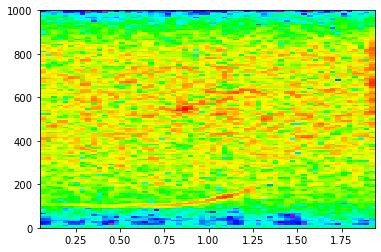

In [9]:
start_time = time.time()     
arrange_transformed_data(train_dir,train_spec_dir)
# save_transformed_data(test_dir,test_spec_dir)
elapsed_time = time.time() - start_time
print(elapsed_time)